In [ ]:
# default_exp analyses

# Alternative Contiguity Analysis
Are contextual associations revealed during free recall stronger for the original or the secondary (or the tertiary) presentation context of repeatedly studied items?

To find out, perform lag-CRP analysis transformed to:
- Only consider transitions from a repeatedly studied item
- Separately measure using lags from primary and secondary (and tertiary) presentation positions

## Data Preparation

In [ ]:
from compmemlearn.datasets import prepare_lohnas2014_data
from compmemlearn.analyses import recall_by_all_study_positions

trials, events, list_length, presentations, list_types, rep_data, subjects = prepare_lohnas2014_data(
    '../../data/repFR.mat')

events.head()

,subject,list,item,input,output,study,recall,repeat,intrusion,condition
0,1,1,0,1,1.0,True,True,0,False,4
1,1,1,1,2,2.0,True,True,0,False,4
2,1,1,2,3,3.0,True,True,0,False,4
3,1,1,3,4,4.0,True,True,0,False,4
4,1,1,4,5,5.0,True,True,0,False,4


## Analysis

In [ ]:
import pandas as pd
import numpy as np

def indices_of_repeated_items(presentation_sequence):

    values, counts = np.unique(presentation_sequence, return_counts=True)
    repeated_items = {v: np.where(presentation_sequence == v)[0] for v in values if counts[v] > 1}

    return {key:repeated_items[key] for key in repeated_items}

# lag thresholding doesn't work reliably with this code, overcounting actual transitions
def alternative_contiguity_test(mixed_presentations, mixed_recalls, lag_threshold, repetition_count):
    relevant_lags = list(range(-int(lag_threshold/2), int(lag_threshold/2+1)))
    del relevant_lags[int(lag_threshold/2)]

    actual_lags = [[0 for each in relevant_lags] for i in range(repetition_count)]
    possible_lags = [[0 for each in relevant_lags] for i in range(repetition_count)]

    for trial_index in range(len(mixed_presentations)):

        # sequence of item indices ordered as they were studied
        presentation = mixed_presentations[trial_index]

        # sequence of initial study positions ordered as they were recalled
        trial_by_study_position = mixed_recalls[trial_index]

        # sequence of item indices ordered as they were recalled
        trial_by_item_index = presentation[trial_by_study_position-1][:np.size(np.nonzero(trial_by_study_position))]

        # {item_index: [presentation indices]} for each repeated item in presentation sequence spaced by >4 items
        i_and_j = indices_of_repeated_items(presentation)
        
        # then for each unique repeated item in the study list, 
        for repeated_item in i_and_j:

            # search for relevant item(s) in recall sequence and skip if not found 
            look_for = trial_by_item_index == presentation[i_and_j[repeated_item][0]]
            for k in range(1, repetition_count):
                look_for = np.logical_or(
                    look_for, trial_by_item_index == presentation[i_and_j[repeated_item][k]])
            recall_positions = np.where(look_for)[0]

            if np.size(recall_positions) == 0:
                continue

            # check each position the item was observed (always just 1 position; we loop for parallelism w control)
            for recall_position in recall_positions:

                # also skip if no successive recall was made, 
                if np.size(trial_by_item_index) == recall_position + 1:
                    continue

                # build list of study positions for items recalled up to repeated item
                prior_lags = [[] for each in range(repetition_count)]
                for i in range(recall_position):

                    # if considered item is also repeated, we track lags wrt to all presentations
                    if trial_by_item_index[i] in i_and_j:
                        for considered in range(len(i_and_j[trial_by_item_index[i]])):
                            for focal in range(repetition_count):
                                prior_lags[focal].append(
                                    int(i_and_j[trial_by_item_index[i]][considered] - i_and_j[repeated_item][focal]))
                    else:
                        for k in range(repetition_count):
                            prior_lags[k].append(int(trial_by_study_position[i] - i_and_j[repeated_item][k]))

                # transition of a given lag is possible if lag not present in prior_lags
                for lag in relevant_lags:
                    for k in range(repetition_count):
                        
                        # skip increment if i_and_j[repeated_item][k] - i_and_j[repeated_item][-1] < lag_threshold
                        if (k > 0) and (i_and_j[repeated_item][k] - i_and_j[repeated_item][k-1] < lag_threshold):
                            continue
                        
                        if lag not in prior_lags[k]:
                            possible_lags[k][relevant_lags.index(lag)] += 1

                # track each serial lag of actually transitioned-to item
                if trial_by_item_index[recall_position+1] in i_and_j:
                    positions = i_and_j[trial_by_item_index[recall_position+1]]
                    for transition_study_position in positions:
                        for k in range(repetition_count):

                            # skip increment if i_and_j[repeated_item][k] - i_and_j[repeated_item][k-1] < lag_threshold
                            if (k > 0) and (i_and_j[repeated_item][k] - i_and_j[repeated_item][k-1] < lag_threshold):
                                continue

                            lag = int(transition_study_position - i_and_j[repeated_item][k])
                            if lag in relevant_lags:
                                actual_lags[k][relevant_lags.index(lag)] += 1
                else:
                    transition_study_position = trial_by_study_position[recall_position+1]-1
                    for k in range(repetition_count):

                        # skip increment if i_and_j[repeated_item][k] - i_and_j[repeated_item][k-1] < lag_threshold
                        if (k > 0) and (i_and_j[repeated_item][k] - i_and_j[repeated_item][k-1] < lag_threshold):
                            continue

                        lag = int(transition_study_position-i_and_j[repeated_item][k])
                        if lag in relevant_lags:
                            actual_lags[k][relevant_lags.index(lag)] += 1

    result = []
    for k in range(repetition_count):
        
        for i in range(len(possible_lags[k])):
            if possible_lags[k][i] == 0:
                possible_lags[k][i] += 1

        result.append(pd.DataFrame(
            {'lag': relevant_lags, 'prob': np.divide(actual_lags[k], possible_lags[k]), 
            'actual': actual_lags[k], 'possible': possible_lags[k]}))

    return pd.concat(result, keys=['From Position {}'.format(i+1) for i in range(repetition_count)], names=['locus'])

In [ ]:
# export

from numba import njit
from numba import int32
import numpy as np

@njit(nogil=True)
def alternative_contiguity(trials, presentations, lag_threshold = 3, max_repeats = 2):
    
    list_length = len(presentations[0])
    lag_range = list_length - 1
    total_actual_lags = np.zeros((max_repeats, lag_range * 2 + 1)) # extended dimension to split by pres positions
    total_possible_lags = np.zeros((max_repeats, lag_range * 2 + 1))
    terminus = np.sum(trials != 0, axis=1) # number of recalls per trial
    recall_by_study_position = recall_by_all_study_positions(trials, presentations, max_repeats)
    
    for trial_index in range(len(trials)):
        previous_item = 0
        item_count = np.max(presentations[trial_index]) + 1
        possible_items = np.arange(item_count) # initial pool of possible recalls, 1-indexed
        possible_positions = np.zeros((item_count, max_repeats), dtype=int32)
        
        # we track possible positions using presentations and alt_presentations
        for item in range(item_count):
            pos = np.nonzero(presentations[trial_index] == item)[0] + 1
            possible_positions[item, :len(pos)] = pos
            
        for recall_index in range(terminus[trial_index]):

            current_item = presentations[trial_index][trials[trial_index, recall_index]-1]
            
            # track possible and actual lags; 
            # focus only on transitions from items with > 1 study positions
            # and only when those multiple study positions have lag over lag
            if recall_index > 0 and np.count_nonzero(
                possible_positions[previous_item]) > 1 and (
                possible_positions[previous_item][1] - possible_positions[previous_item][0] >= lag_threshold):
                
                # item indices don't help track lags anymore
                # so more complex calculation needed to identify possible lags given previous item
                current_index = np.nonzero(possible_items==current_item)[0]

                index = 0
                for x in range(len(recall_by_study_position)):
                    for y in range(len(recall_by_study_position)):
                        if possible_positions[previous_item, y] > 0:
                        
                            possible_lags = possible_positions[
                                possible_items, x] - possible_positions[previous_item, y]
                            
                            # if tracked position is 0, then we don't actually want to count it in our lags
                            possible_lags[possible_positions[possible_items, x] == 0] = 0
                            
                            # we track actual lag at each iteration
                            actual_lag = possible_lags[current_index] + lag_range
                            total_actual_lags[y][actual_lag] += 1

                            # we track possible lag at each iteration
                            possible_lags += lag_range
                            total_possible_lags[y][possible_lags] += 1
                        
                        index += 1

            # update pool to exclude recalled item (updated to still identify 1-indexed item)
            previous_item = current_item
            possible_items = possible_items[possible_items != previous_item]

                                
    # small correction to avoid nans and commit to excluding multiply-tracked single presentations 
    total_actual_lags[:, lag_range] = 0
    for i in range(max_repeats):
        total_possible_lags[i][total_actual_lags[i]==0] += 1
    
    return total_actual_lags/total_possible_lags

In [ ]:
#selection = list_types == 4
#alternative_contiguity(trials[selection], presentations[selection], 6, 2)


individual_results = []

for subject in np.unique(subjects):
    selection = np.logical_and(list_types == 4, subjects == subject)

    individual_results.append(
        alternative_contiguity(trials[selection], presentations[selection], 6, 2))

np.mean(np.array(individual_results), axis=0)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.00952381, 0.00714286,
        0.02357143, 0.00571429, 0.01285714, 0.01428571, 0.03505495,
        0.00571429, 0.0155102 , 0.04619048, 0.00505495, 0.01569264,
        0.03380952, 0.02346939, 0.02984127, 0.03125953, 0.02119417,
        0.03478997, 0.02337276, 0.02438032, 0.04757342, 0.04654344,
        0.03749433, 0.07345434, 0.06505376, 0.14134409, 0.        ,
        0.17722157, 0.1074913 , 0.05463955, 0.06811201, 0.0654523 ,
        0.07416891, 0.07620522, 0.06610723, 0.05367311, 0.05347731,
        0.04190581, 0.02654247, 0.01420171, 0.02639528, 0.02579365,
        0.01405699, 0.01496599, 0.01760597, 0.02278912, 0.01939549,
        0.02042735, 0.01525903, 0.02315018, 0.00952381, 0.01360544,
        0.02952381, 0.03979592, 0.0152381 , 0.02579365, 0.02380952,
        0.00714286, 0.03428571, 0.01047619, 0.  

## Plotting

In [ ]:
minimum_lag = 6
repetition_count = 2

individual_results = []

for subject in np.unique(subjects):
    selection = np.logical_and(list_types == 4, subjects == subject)

    individual_results.append(
        alternative_contiguity_test(presentations[selection], trials[selection], minimum_lag, repetition_count))

df = pd.concat(individual_results, keys=np.unique(subjects), names=['subject']).reset_index()
df.drop(['level_2'], axis=1, inplace=True)
df

,subject,locus,lag,prob,actual,possible
0,1,From Position 1,-3,0.000000,0,27
1,1,From Position 1,-2,0.115385,3,26
2,1,From Position 1,-1,0.153846,4,26
3,1,From Position 1,1,0.200000,8,40
4,1,From Position 1,2,0.314286,11,35
...,...,...,...,...,...,...
415,37,From Position 2,-2,0.125000,1,8
416,37,From Position 2,-1,0.142857,1,7
417,37,From Position 2,1,0.333333,2,6
418,37,From Position 2,2,0.000000,0,9


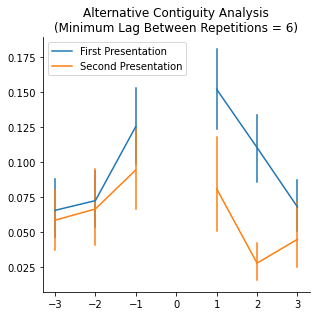

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

max_lag = minimum_lag/2
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

g = sns.FacetGrid(df, height=4.5)
g.map_dataframe(
    lambda data, **kws: sns.lineplot(
        data=data.query(filt_neg), x='lag', y='prob', hue='locus', err_style='bars', **kws)
)

g.map_dataframe(
    lambda data, **kws: sns.lineplot(
        data=data.query(filt_pos), x='lag', y='prob', hue='locus', err_style='bars', **kws)
)

plt.legend(['First Presentation', 'Second Presentation'], loc='upper left')
plt.title('Alternative Contiguity Analysis\n(Minimum Lag Between Repetitions = {})'.format(minimum_lag))
plt.tight_layout()

In [ ]:
%timeit alternative_contiguity(trials[selection], presentations[selection], 6, 2)

4.14 ms ± 69.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
